In [1]:
from dotenv import load_dotenv
from service.s3_storage_service import S3StorageService
from storage.s3_client import S3Client
from service.nrfa_data_service import NRFADataService
from service.hydrology_data_service import HydrologyDataService

load_dotenv() # Load environment variable with the bucket name. 
s3_client = S3Client().get_client()
s3_service = S3StorageService(s3_client)
hydro_service = HydrologyDataService()

## Function used to extract and operate on hydrology data

In [2]:
import requests

base_url = "http://environment.data.gov.uk/hydrology/id/"

def get_active_stations(observed_property):
    """Retrieve active monitoring stations for a specific observed property (e.g., waterFlow or waterLevel)."""
    endpoint = f"{base_url}stations"
    params = {
        'status.label': 'Active',
        'observedProperty': observed_property,
        '_limit': 10000  # Increase limit as needed

    }
    response = requests.get(endpoint, params=params)
    return response.json()


def get_station_measures_by_guid(station_guid):
    """Retrieve available measures for a specific station."""
    endpoint = f"{base_url}measures"
    params = {
        'station': station_guid
    }
    response = requests.get(endpoint, params=params)
    data = response.json()
    return data


In [3]:
def get_active_stations_count(observed_property):
    """Retrieve counts of active monitoring stations with and without NRFA IDs for a specific observed property."""
    endpoint = f"{base_url}stations"
    params = {
        'status.label': 'Active',
        'observedProperty': observed_property,
        '_limit': 10000  # Assuming a high limit to fetch all relevant stations
    }
    response = requests.get(endpoint, params=params)
    if response.status_code == 200:
        data = response.json()
        total_stations = len(data['items'])
        stations_with_nrfa = sum('nrfaStationID' in station for station in data['items'])
        stations_without_nrfa = total_stations - stations_with_nrfa

        return {
            "total_stations": total_stations,
            "stations_with_nrfa": stations_with_nrfa,
            "stations_without_nrfa": stations_without_nrfa
        }
    else:
        return f"Error: {response.status_code}"
    
observed_property = "waterLevel"  # or "waterFlow", etc.
station_counts = get_active_stations_count(observed_property)
print(station_counts)

{'total_stations': 2654, 'stations_with_nrfa': 672, 'stations_without_nrfa': 1982}


In [4]:
def get_station_info(id):
    endpoint = f"{base_url}stations/{id}"
    
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()
    else:
        return f"Error: {response.status_code}"

In [5]:
# Gets information about the typical range upper and lower limit of the water level

import requests

def get_station_detailed_info_from_ref(station_id):
    
    # Endpoint to get basic station info
    initial_endpoint = f"{base_url}stations/{station_id}.json"
    
    # Make the initial API call to get the basic station information
    initial_response = requests.get(initial_endpoint)
    if initial_response.status_code == 200:
        initial_data = initial_response.json()
        
        # Assuming 'stationReference' can be directly extracted from the initial response
        # Here we adjust based on your data structure, ensuring we access the correct field
        station_reference = initial_data['items'][0]['stationReference'] if 'items' in initial_data and len(initial_data['items']) > 0 else None
        
        if station_reference:
            # Construct the URL manually using the station reference
            detailed_url = f"https://environment.data.gov.uk/flood-monitoring/id/stations/{station_reference}"
            
            # Make a second API call to the manually constructed URL to get detailed station information
            detailed_response = requests.get(detailed_url)
            if detailed_response.status_code == 200:
                detailed_data = detailed_response.json()
                
                # Extract the typical range high and low from the detailed data
                typical_range_high = detailed_data['items']['stageScale']['typicalRangeHigh']
                typical_range_low = detailed_data['items']['stageScale']['typicalRangeLow']
                
                return {
                    "typicalRangeHigh": typical_range_high,
                    "typicalRangeLow": typical_range_low
                }
            else:
                return f"Error fetching detailed info: {detailed_response.status_code}"
        else:
            return "Station reference not found in initial response."
    else:
        return f"Error fetching initial info: {initial_response.status_code}"





In [6]:
stations_response = get_active_stations('waterLevel')

def create_id_map(data):
    id_map = []
    for item in data['items']:
        entry = {
            "guid": item['stationGuid'],
            "nrfa": item.get('nrfaStationID', 'N/A'),  # Using .get() for safe access
            "wiski": item.get('wiskiID', 'N/A')
        }
        id_map.append(entry)
    return id_map

def get_guid_by_nrfa_id(nrfa_id, mapping):
    """
    Retrieve the GUID for a given NRFA ID from the mapping list.

    Parameters:
    - nrfa_id (str): The NRFA ID to search for.
    - mapping (list): The list containing mappings of GUID, NRFA, and Wiski IDs.

    Returns:
    - str: The GUID corresponding to the given NRFA ID, or None if not found.
    """
    nrfa_id_str = str(nrfa_id)
    for item in mapping:
        if item['nrfa'] == nrfa_id_str:
            return item['guid']
    return None

station_ids = create_id_map(stations_response)
# print(station_ids)

# Assume you choose a station and want to get measures for it
station_id = 21035
station_guid = get_guid_by_nrfa_id(station_id, station_ids)

# print(f"station_guid = {station_guid}")
station_measures = get_station_measures_by_guid(station_guid)
print(station_measures)
# station_info = get_station_info(station_guid)
# # print(station_measures)
# print(station_info)
station_info = get_station_detailed_info_from_ref(station_guid)
print(station_info)


{'meta': {'@id': 'http://environment.data.gov.uk/hydrology/id/measures?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'publisher': 'Environment Agency', 'license': 'http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/', 'licenseName': 'OGL 3', 'comment': 'Hydrology API for sub-daily data', 'version': '2.0.0', 'hasFormat': ['http://environment.data.gov.uk/hydrology/id/measures.html?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'http://environment.data.gov.uk/hydrology/id/measures.ttl?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'http://environment.data.gov.uk/hydrology/id/measures.csv?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'http://environment.data.gov.uk/hydrology/id/measures.rdf?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'http://environment.data.gov.uk/hydrology/id/measures.json?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1', 'http://environment.data.gov.uk/hydrology/id/measures.geojson?station=20152e19-e61b-40ff-ae0a-bfd520b41ad1']}, 'items': [{'@id'

In [7]:
import pandas as pd

def generate_csv_urls(measures_data):
    """Generate CSV URLs for daily measures (flow and level min, max, mean) with specific measurement type."""
    csv_urls = []
    for item in measures_data['items']:
        if item.get('period') == 86400:
            parameter_name = item.get('parameterName', '').lower()
            # Creating more specific identifiers for column names
            if 'flow' in parameter_name:
                prefix = 'f'  # Shorten flow to 'f'
            elif 'level' in parameter_name:
                prefix = 'l'  # Shorten level to 'l'
            else:
                continue  # Skip if neither flow nor level

            valueType = item.get('valueType', '').lower()
            if valueType:  # Append valueType (min, max, mean) if present
                specific_name = f"{prefix}{valueType}"
            else:
                specific_name = prefix
            
            measure_id_url = item['@id']
            csv_url = f"{measure_id_url}/readings.csv"
            csv_urls.append((csv_url, specific_name))
    return csv_urls


def load_csv_data_to_dataframe(csv_urls):
    """Load CSV data from URLs into Pandas DataFrame, using the 'date' column."""
    dfs = []
    for url, parameterName in csv_urls:
        df = pd.read_csv(url, usecols=['date', 'value'])
        # Rename the 'value' column to match the parameterName for clarity
        df.rename(columns={'value': parameterName}, inplace=True)
        # Ensure 'date' is in datetime format for easy handling
        df['date'] = pd.to_datetime(df['date'])
        dfs.append(df)
    
    # Assuming all dfs have a 'date' column, merge them on this column
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = pd.merge(combined_df, df, on='date', how='outer')
    
    # Sort by date to maintain chronological order
    combined_df.sort_values(by='date', inplace=True)
    combined_df.reset_index(drop=True, inplace=True)
    combined_df.set_index('date', inplace=True)
    
    return combined_df



In [8]:
csv_urls = generate_csv_urls(station_measures)
print(csv_urls)
final_df = load_csv_data_to_dataframe(csv_urls)

[('http://environment.data.gov.uk/hydrology/id/measures/20152e19-e61b-40ff-ae0a-bfd520b41ad1-flow-m-86400-m3s-qualified/readings.csv', 'fmean'), ('http://environment.data.gov.uk/hydrology/id/measures/20152e19-e61b-40ff-ae0a-bfd520b41ad1-flow-min-86400-m3s-qualified/readings.csv', 'fmin'), ('http://environment.data.gov.uk/hydrology/id/measures/20152e19-e61b-40ff-ae0a-bfd520b41ad1-flow-max-86400-m3s-qualified/readings.csv', 'fmax'), ('http://environment.data.gov.uk/hydrology/id/measures/20152e19-e61b-40ff-ae0a-bfd520b41ad1-level-min-86400-m-qualified/readings.csv', 'lmin'), ('http://environment.data.gov.uk/hydrology/id/measures/20152e19-e61b-40ff-ae0a-bfd520b41ad1-level-max-86400-m-qualified/readings.csv', 'lmax')]


In [9]:
print(final_df.head())
print(final_df.tail())

            fmean  fmin  fmax   lmin   lmax
date                                       
2001-11-22    NaN   NaN   NaN    NaN  0.592
2001-11-23   5.92   NaN  6.55  0.479  0.478
2001-11-24   5.59  5.58  5.70  0.440  0.445
2001-11-25   5.39  5.48  5.53  0.436  0.438
2001-11-26   5.09  5.27  5.29  0.427  0.428
            fmean  fmin  fmax  lmin  lmax
date                                     
2024-04-05   64.7   NaN   NaN   NaN   NaN
2024-04-06   53.5   NaN   NaN   NaN   NaN
2024-04-07   38.2   NaN   NaN   NaN   NaN
2024-04-08   28.1   NaN   NaN   NaN   NaN
2024-04-09   45.7   NaN   NaN   NaN   NaN


In [10]:
df = final_df.dropna()

print(df.head())
print(df.tail())

            fmean  fmin  fmax   lmin   lmax
date                                       
2001-11-24   5.59  5.58  5.70  0.440  0.445
2001-11-25   5.39  5.48  5.53  0.436  0.438
2001-11-26   5.09  5.27  5.29  0.427  0.428
2001-11-30   8.89  8.12  8.09  0.533  0.532
2001-11-30   8.89  8.12  8.09  0.533  0.570
            fmean   fmin   fmax   lmin   lmax
date                                         
2023-10-04   2.86   1.97   2.06  0.313  0.321
2023-10-06   4.18   2.21   2.22  0.329  0.331
2023-10-07  29.80   5.92   5.71  0.523  0.516
2023-10-09  22.00  21.40  21.30  0.953  0.948
2023-10-10  13.20  11.50  11.50  0.711  0.709


In [11]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
data = df.values

scaler = MinMaxScaler(feature_range=(0,1))
data_normalised = scaler.fit_transform(data)

n_input = 28 # Number of input data required for prediction (previous 128 days)
n_output = 7 # Number of predicted days based on past data
n_features = 5
batch_size = 32 

# Split data into training and test sets (70% training, 30% testing)
split_percent = 0.95
split_index = int(len(data_normalised) * split_percent)

train_data = data_normalised[:split_index]
test_data = data_normalised[split_index - n_input:]

lmax_index = 4 #Index for the target columne - we are targetting max level of the river - lmax 

#Generators:
train_generator = TimeseriesGenerator(train_data, train_data[:,lmax_index], length=n_input, batch_size=batch_size, stride=1, sampling_rate=1)
test_generator = TimeseriesGenerator(test_data, test_data[:, lmax_index], length=n_input, batch_size=batch_size, stride=1, sampling_rate=1)

# Print some generator details to confirm setup
for i, (x, y) in enumerate(train_generator):
    print(f"Batch {i}:")
    print(f"X shape: {x.shape}, Y shape: {y.shape}")
    # Print details for the first batch and break
    if i == 0:
        break

2024-04-11 09:34:25.324608: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 09:34:25.344029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 09:34:25.344048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 09:34:25.344505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 09:34:25.347874: I tensorflow/core/platform/cpu_feature_guar

Batch 0:
X shape: (32, 28, 5), Y shape: (32,)


In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential([
    # LSTM layer with 50 units, input shape based on generator's settings
    LSTM(128, return_sequences=False,  input_shape=(n_input, n_features)),
    Dropout(0.2),
    Dense(n_output)
])

# model = Sequential([
#     GRU(256, return_sequences=False, input_shape=(n_input, n_features)), 
#     Dropout(0.2),
#     Dense(n_output)
# ])

# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=0.005)) # Huber selected for higher sensitivity to outliers than MSE
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
# Summary of the model
model.summary()

# Define EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')

# Train the model
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=14,
                    callbacks=[early_stopping])

# Note: Depending on your data, you might need to adjust the model architecture, 
# learning rate, epochs, and batch size for optimal performance.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 128)               68608     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 7)                 903       
                                                                 
Total params: 69511 (271.53 KB)
Trainable params: 69511 (271.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
261/261 [==============================] - 2s 5ms/step - loss: 1.3697e-04 - val_loss: 6.8892e-05
Epoch 2/20
261/261 [==============================] - 1s 4ms/step - loss: 8.9818e-05 - val_loss: 5.7333e-05
Epoch 3/20
261/261 [==============================] - 1s 4ms/ste

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a 'scaler' object used for normalization
# and 'test_generator' that was used for testing the model

# Generate predictions for the test data
predictions = model.predict(test_generator)

predictions_reshaped = predictions.reshape(-1, 1)

# Collect the actual y values from the test generator
actuals = []
for _, y in test_generator:
    actuals.extend(y)
y_test = np.array(actuals)

y_test_reshaped = y_test.reshape(-1, 1)

14/14 [==============================] - 0s 3ms/step


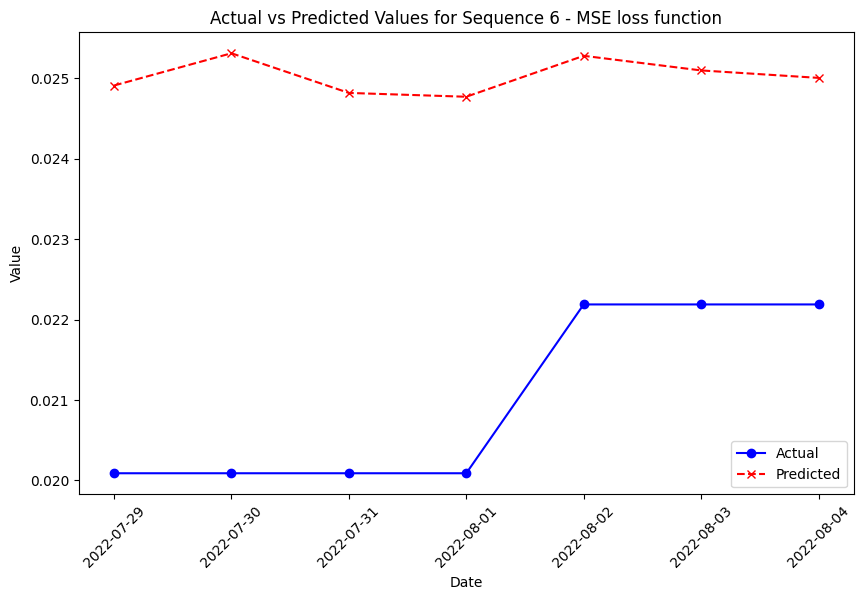

In [68]:
# Example: Plotting the first prediction sequence
sequence_num = 5# Change this to plot different sequences
prediction_length = n_output  # Number of steps predicted

# Assuming `predictions` is your model output and has shape (num_sequences, prediction_length)
# And `actuals` is a flattened array of actual values of length 'n'
sequence_predictions = predictions[sequence_num].flatten()  # Get the first sequence of predictions

# Calculate start and end indices for actual values that correspond to this sequence
actual_start_index = sequence_num * prediction_length
actual_end_index = actual_start_index + prediction_length

sequence_actuals = actuals[actual_start_index:actual_end_index]

# Generate dates/timesteps for plotting (replace with actual dates if available)
dates = pd.date_range(start=df.index[split_index], periods=prediction_length, freq="D")  # Example date range

# Plot
plt.figure(figsize=(10, 6))
plt.plot(dates, sequence_actuals, label="Actual", marker='o', color='blue')
plt.plot(dates, sequence_predictions, label="Predicted", linestyle='--', marker='x', color='red')
plt.title(f'Actual vs Predicted Values for Sequence {sequence_num+1} - MSE loss function')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [69]:
def plot_aggregated_predictions(test_generator, model_predictions, scaler, original_df, n_output, feature_index, split_index, n_input):
    """
    Plots aggregated model predictions against actual values for the entire test dataset,
    taking into consideration the specific feature index for inverse transformation.

    Parameters:
    - test_generator: The generator used for testing the model.
    - model_predictions: Predictions made by the model on the test_generator.
    - scaler: MinMaxScaler instance used to scale the dataset.
    - original_df: Original DataFrame used for the model training and testing.
    - n_output: Number of steps predicted by the model in each sequence.
    - feature_index: Index of the target feature in the original dataset for inverse scaling.
    - split_index: The index where the test data starts in the original DataFrame.
    """
    if model_predictions.ndim > 2:
        model_predictions = model_predictions.reshape(model_predictions.shape[0], -1)
    averaged_predictions = np.mean(model_predictions, axis=1)

    print(f"Model predictions reshaped: {model_predictions.shape}")
    print(f"Averaged predictions: {averaged_predictions.shape}")
    
    # Prepare the dummy array for inverse scaling
    dummy_array = np.zeros((len(averaged_predictions), original_df.shape[1]))
    dummy_array[:, feature_index] = averaged_predictions


    prediction_start_index = split_index + n_input
    prediction_end_index = prediction_start_index + len(averaged_predictions)
    # Inverse transform the dummy array
    predictions_inverse = scaler.inverse_transform(dummy_array)[:, feature_index]
    
    # Trim the prediction data by the initial input of n_input data points. 
    predictions_inverse = predictions_inverse[n_input:]


    print(f"Prediction start index: {prediction_start_index}")
    print(f"Prediction end index: {prediction_end_index}")
    # Prepare the actual values
    # actuals = original_df.iloc[split_index + len(test_generator) - len(averaged_predictions):split_index + len(test_generator), feature_index]
    actuals = original_df.iloc[prediction_start_index:prediction_end_index][original_df.columns[feature_index]]
    print(f"Actuals length: {len(actuals)}")

    # Correctly calculate the start date for the test data predictions
    # This accounts for the 'length' of the test_generator sequences
    test_data_start_date = df.index[prediction_start_index]
    print(f"Test data start date: {test_data_start_date}")
    print(f"Test data start date: {df.index[-1]}")


    end_date = df.index[-1]
    
    # Calculate the date range
    date_range_length = pd.date_range(start=test_data_start_date, end=end_date)
    
    # Print the length of the date range
    print(f"Length of date range: {len(date_range_length)}")
    # Generate the date range for plotting, adjusted for the length of averaged_predictions
    prediction_dates = pd.date_range(start=test_data_start_date, periods=actuals.shape[0], freq='D')
    print(f"Prediction dates length: {len(prediction_dates)}")
    print(f"Length of predictions_inverse: {len(predictions_inverse)}")

    # Plotting code remains the same...
    plt.figure(figsize=(10, 6))
    plt.plot(prediction_dates, actuals.values, label='Actual lmax', color='blue')
    plt.plot(prediction_dates, predictions_inverse, label='Predicted lmax', color='red')
    plt.title('Actual vs Predicted lmax Values')
    plt.xlabel('Date')
    plt.ylabel('lmax Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [70]:
plot_aggregated_predictions(test_generator, predictions, scaler, df, n_output=n_output, feature_index=lmax_index, split_index=split_index, n_input=n_input)


Model predictions reshaped: (440, 7)
Averaged predictions: (440,)


ValueError: operands could not be broadcast together with shapes (440,8) (3,) (440,8) 

In [71]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming you have lists or need to ensure these are numpy arrays
true_values = np.array(actuals)  # Convert to NumPy array if it's not already
predictions = np.array(predictions)  # Convert to NumPy array if it's not already


In [72]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

# Initialize an empty list to store RMSE for each prediction window
rmse_values = []

# Loop through the dataset, aligning each prediction with its corresponding actual values
for i in range(len(true_values) - n_output):
    # Extract the actual values for the next 7 days
    actuals_for_window = true_values[i:i+n_output]
    
    # Extract the corresponding set of predictions
    predictions_for_window = predictions[i]
    
    # Calculate the RMSE for this window and append to our list
    rmse = sqrt(mean_squared_error(actuals_for_window, predictions_for_window))
    rmse_values.append(rmse)

# Optionally, calculate the average RMSE across all windows for an overall performance metric
average_rmse = np.mean(rmse_values)

print(f"Average RMSE across all sliding windows: {average_rmse}")


Average RMSE across all sliding windows: 0.022773345267450874


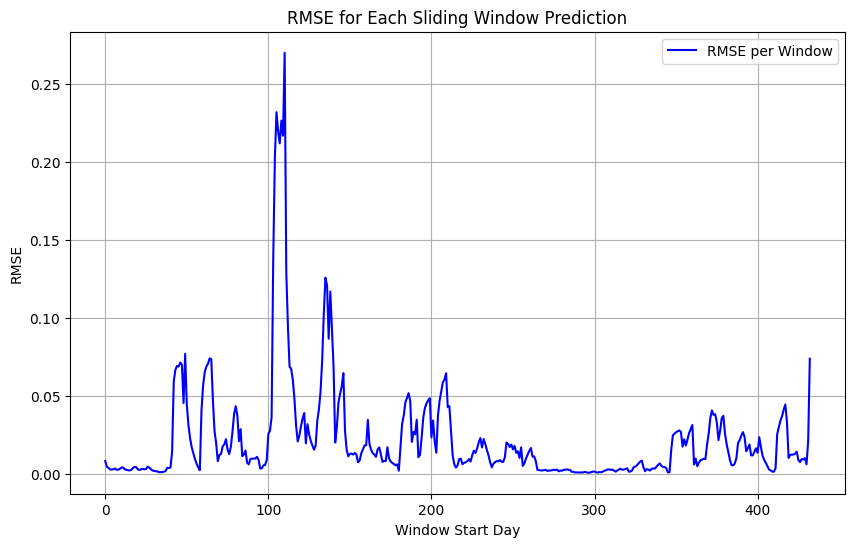

In [65]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(rmse_values, label='RMSE per Window', color='blue')  # Plot RMSE values
plt.title('RMSE for Each Sliding Window Prediction')  # Title of the plot
plt.xlabel('Window Start Day')  # X-axis label
plt.ylabel('RMSE')  # Y-axis label
plt.legend()  # Add a legend
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming `df` is your DataFrame and 'lmax' is the column you want to predict
lags = 3  # Number of lag observations to use as input variables
features = ['lmax']  # This can be expanded to include more features

# Create lagged features for 'lmax'
for i in range(1, lags + 1):
    df[f'lmax_lag_{i}'] = df['lmax'].shift(i)

# Drop rows with NaN values resulting from lagging
df = df.dropna()

# Prepare the features (X) and target (y)
X = df[[f'lmax_lag_{i}' for i in range(1, lags + 1)]].values
y = df['lmax'].values

# Note: Additional features can be added to X as needed

### Step 2: Scaling the Features

# Initialize the StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Step 3: Splitting the Data into Training and Testing Sets

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Step 4: Define and Train the SVM Model

# Define the SVR model
model = SVR(C=1.0, epsilon=0.1)

# Train the model
model.fit(X_train, y_train)

### Step 5: Making Predictions and Evaluating the Model

# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')



RMSE: 0.11680917233272625


/tmp/ipykernel_61717/2068884184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lmax_lag_{i}'] = df['lmax'].shift(i)
/tmp/ipykernel_61717/2068884184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lmax_lag_{i}'] = df['lmax'].shift(i)
/tmp/ipykernel_61717/2068884184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

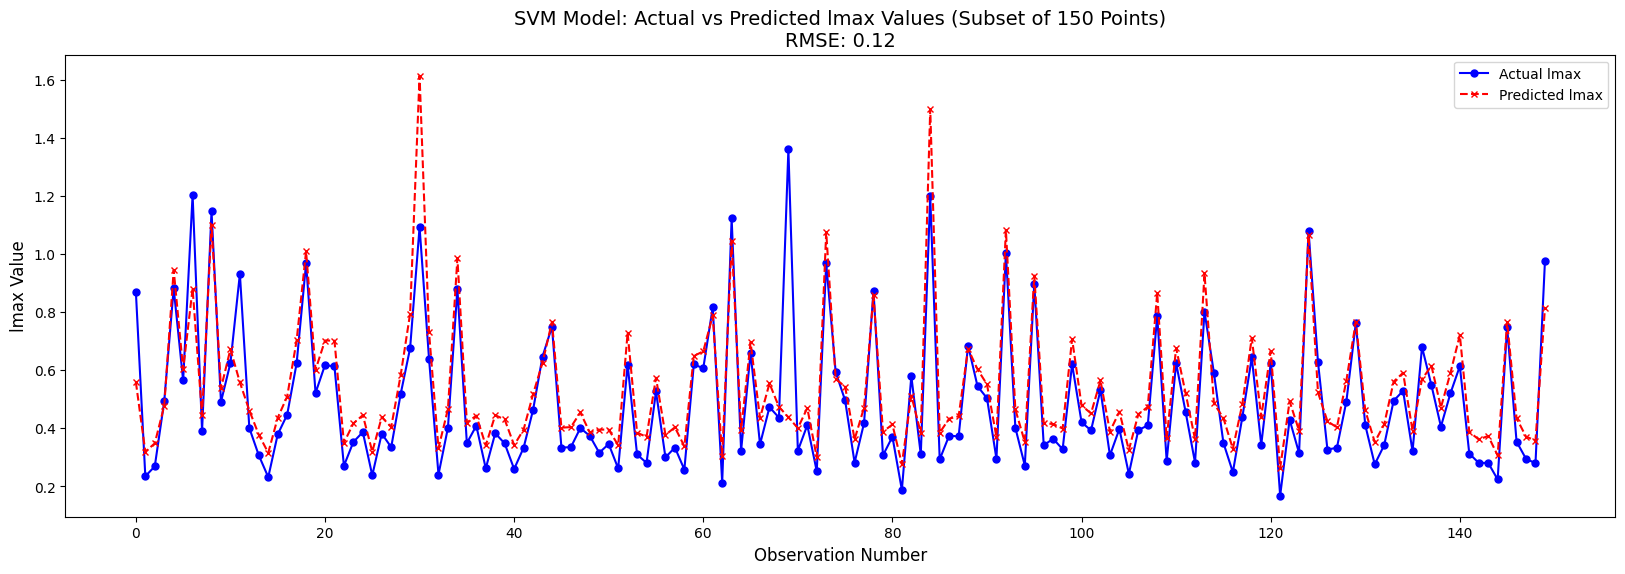

In [23]:
# Example: Plotting a subset of 100 data points
subset_size = 150  # Number of points to plot
start_index = 0  # Starting index of the subset
end_index = start_index + subset_size  # Ending index

plt.figure(figsize=(20, 6))
plt.plot(y_test[start_index:end_index], label='Actual lmax', marker='o', linestyle='-', markersize=5, color='blue')
plt.plot(y_pred[start_index:end_index], label='Predicted lmax', marker='x', linestyle='--', markersize=5, color='red')
plt.title(f'SVM Model: Actual vs Predicted lmax Values (Subset of {subset_size} Points)\nRMSE: {rmse:.2f}', fontsize=14)
plt.xlabel('Observation Number', fontsize=12)
plt.ylabel('lmax Value', fontsize=12)
plt.legend()
plt.show()
